In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pprint
from collections import Counter

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.svm import SVC

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [48]:
def balance_train_data(X, y, method=None):
    uniq, cts = np.unique(y, return_counts=True)
    
    if method == None:
        return X, y
    
    elif method == 'undersampling':
        rus = RandomUnderSampler()
        X_train, y_train = rus.fit_resample(X, y)
        return X_train, y_train
    
    elif method == 'oversampling':    
        ros = RandomOverSampler()
        X_train, y_train = ros.fit_resample(X, y)
        return X_train, y_train
    
    elif method == 'smote':
        smote = SMOTE()
        X_train, y_train = smote.fit_resample(X, y)
        return X_train, y_train
    
    elif method == 'both':
        smote = SMOTE(sampling_strategy=0.75)
        under = RandomUnderSampler(sampling_strategy=1)
        X_train, y_train = smote.fit_resample(X, y)
        X_train, y_train = under.fit_resample(X_train, y_train)
        return X_train, y_train

    else:
        print('Incorrect balance method')
        return

def plot_cross_val(models, data, ax, sampling_method):

    X = data['cleanText'].to_numpy()
    y = data['vote'].to_numpy()

    kf = KFold(n_splits=5, shuffle=True)

    precisions = [[], []] 
    recalls = [[], []]
    
    for train, test in kf.split(X):
        X_test, y_test = X[test], y[test]
        X_train, y_train = X[train], y[train]
        
        tfidf = TfidfVectorizer()
        train_vectors = tfidf.fit_transform(X_train)
        test_vectors = tfidf.transform(X_test)  
        
        train_vectors, y_train = balance_train_data(train_vectors, y_train, method=sampling_method)
         
        for i, model in enumerate(models):
            model.fit(train_vectors, y_train)
            y_pred = model.predict(test_vectors)
            
            precisions[i].append(precision_score(y_test, y_pred))
            recalls[i].append(recall_score(y_test, y_pred))
    
    x = range(0, 5)
    colormap = {0 : 'r',
                1 : 'b',
                2 : 'g'}
    
    
    names = ['Default GB', 'Optimized GB']
    for i in range(len(models)):
        ax.plot(x, precisions[i], c=colormap[i], 
                linewidth=1, linestyle='-',
                label='%s Precision' % names[i])
        ax.plot(x, recalls[i], c=colormap[i], 
                linewidth=1, linestyle='--',
                label='%s Recall' % names[i])

In [39]:
data = pd.read_csv('data/clean/Breyer.csv')
X = data['cleanText'].fillna(' ').to_numpy()
y = data['vote'].to_numpy()

model = make_pipeline(TfidfVectorizer(), 
                      SMOTE(),
                      RandomForestClassifier())

params = {'randomforestclassifier__max_depth': [3, None],
          'randomforestclassifier__max_features': ['sqrt', 'log2', None],
          'randomforestclassifier__n_estimators': [75, 100, 150],
          'randomforestclassifier__criterion': ['gini', 'entropy'],
          'randomforestclassifier__random_state': [1]}

grid = GridSearchCV(model, 
                    params, 
                    n_jobs=-1,
                    verbose=True,
                    scoring='recall')
grid.fit(X, y)

print("best parameters:", grid.best_params_)

best_rf_model = grid.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  8.2min finished


best parameters: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__random_state': 1}


In [37]:
best_parameters = {'randomforestclassifier__bootstrap': True, 
                  'randomforestclassifier__criterion': 'gini', 
                  'randomforestclassifier__max_depth': 3, 
                  'randomforestclassifier__max_features': 'sqrt',  
                  'randomforestclassifier__n_estimators': 75, 
                  'randomforestclassifier__random_state': 1}

best_smote_parameters = {
                  'randomforestclassifier__criterion': 'entropy', 
                  'randomforestclassifier__max_depth': 3, 
                  'randomforestclassifier__max_features': 'sqrt',  
                  'randomforestclassifier__n_estimators': 100, 
                  'randomforestclassifier__random_state': 1}

Text(0.5, 0, '# of Folds')

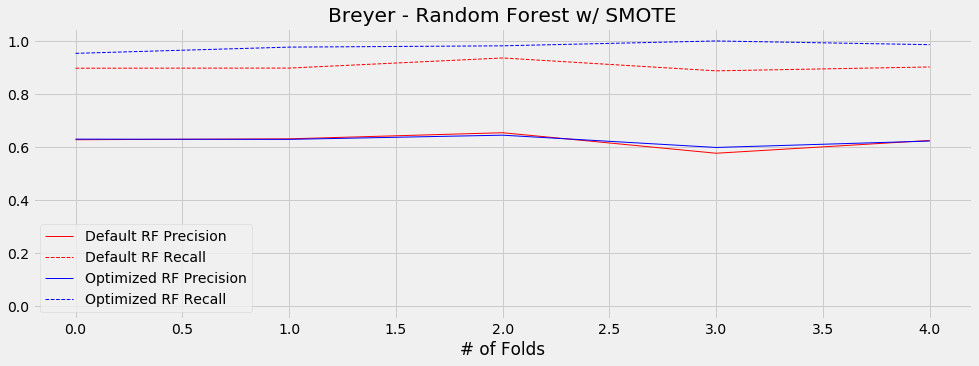

In [41]:
data = pd.read_csv('data/clean/Breyer.csv')
X = data['cleanText'].fillna(' ').to_numpy()
y = data['vote'].to_numpy()

default_rf = RandomForestClassifier()
best_rf = RandomForestClassifier(criterion='entropy',
                                max_depth=3, max_features='sqrt', 
                                n_estimators=100)

fig, ax = plt.subplots(figsize=(15, 5))
models = [default_rf, best_rf]

data = pd.read_csv('data/clean/Breyer.csv')
data['cleanText'] = data['cleanText'].fillna(' ')
plot_cross_val(models, data, ax, 'smote')
ax.set_title('Breyer - Random Forest w/ SMOTE')
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel('# of Folds')



In [13]:
data = pd.read_csv('data/clean/Breyer.csv')
X = data['cleanText'].fillna(' ').to_numpy()
y = data['vote'].to_numpy()

In [43]:
model = make_pipeline(TfidfVectorizer(), 
                      SMOTE(),
                      GradientBoostingClassifier())

params = {'gradientboostingclassifier__max_depth': [3, None],
          'gradientboostingclassifier__max_features': ['sqrt', 'log2', None],
          'gradientboostingclassifier__n_estimators': [75, 100, 150],
          'gradientboostingclassifier__loss': ['deviance', 'exponential'],
          'gradientboostingclassifier__random_state': [1]}

grid = GridSearchCV(model, 
                    params, 
                    n_jobs=-1,
                    verbose=True,
                    scoring='recall')
grid.fit(X, y)

print("best parameters:", grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 13.3min finished


best parameters: {'gradientboostingclassifier__loss': 'deviance', 'gradientboostingclassifier__max_depth': None, 'gradientboostingclassifier__max_features': 'log2', 'gradientboostingclassifier__n_estimators': 150, 'gradientboostingclassifier__random_state': 1}


In [ ]:
best_parameters: {'gradientboostingclassifier__loss': 'exponential', 
                  'gradientboostingclassifier__max_depth': None, 
                  'gradientboostingclassifier__max_features': 'log2', 
                  'gradientboostingclassifier__n_estimators': 150, 
                  'gradientboostingclassifier__random_state': 1}
    
best_smote_parameters: {'gradientboostingclassifier__loss': 'deviance', 
                  'gradientboostingclassifier__max_depth': None, 
                  'gradientboostingclassifier__max_features': 'log2', 
                  'gradientboostingclassifier__n_estimators': 150, 
                  'gradientboostingclassifier__random_state': 1}

Text(0.5, 0, '# of Folds')

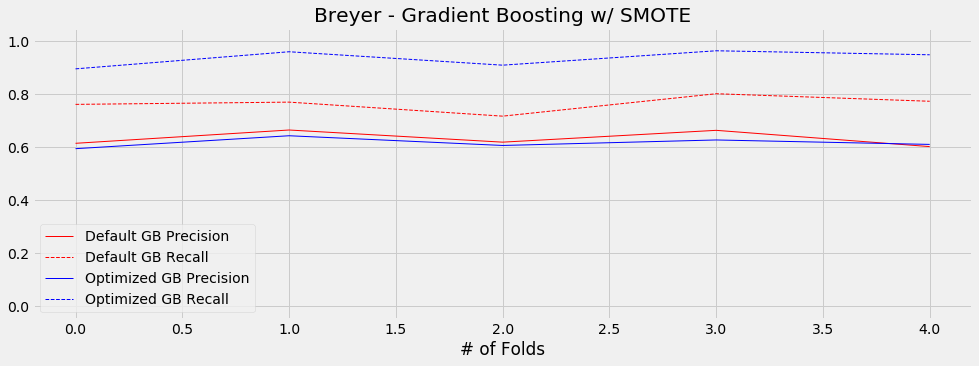

In [49]:
default_gb = GradientBoostingClassifier()
best_gb = GradientBoostingClassifier(loss='deviance', 
                                     max_depth=None, 
                                     max_features='log2', 
                                     n_estimators=150, 
                                     learning_rate=0.01)

fig, ax = plt.subplots(figsize=(15, 5))
models = [default_gb, best_gb]

data = pd.read_csv('data/clean/Breyer.csv')
data['cleanText'] = data['cleanText'].fillna(' ')
plot_cross_val(models, data, ax, 'smote')
ax.set_title('Breyer - Gradient Boosting w/ SMOTE')
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel('# of Folds')




In [6]:
data = pd.read_csv('data/clean/Breyer.csv')
X = data['cleanText'].fillna(' ').to_numpy()
y = data['vote'].to_numpy()


model = make_pipeline(TfidfVectorizer(), 
                      LogisticRegression())

params = {'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'none'],
          'logisticregression__fit_intercept': [False, True],
          'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'logisticregression__random_state': [1]}

grid = GridSearchCV(model, 
                    params, 
                    n_jobs=-1,
                    verbose=True,
                    scoring='recall')
grid.fit(X, y)

print("best parameters:", grid.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   42.6s finished


best parameters: {'logisticregression__fit_intercept': True, 'logisticregression__penalty': 'l1', 'logisticregression__random_state': 1, 'logisticregression__solver': 'liblinear'}


Text(0.5, 0, '# of Folds')

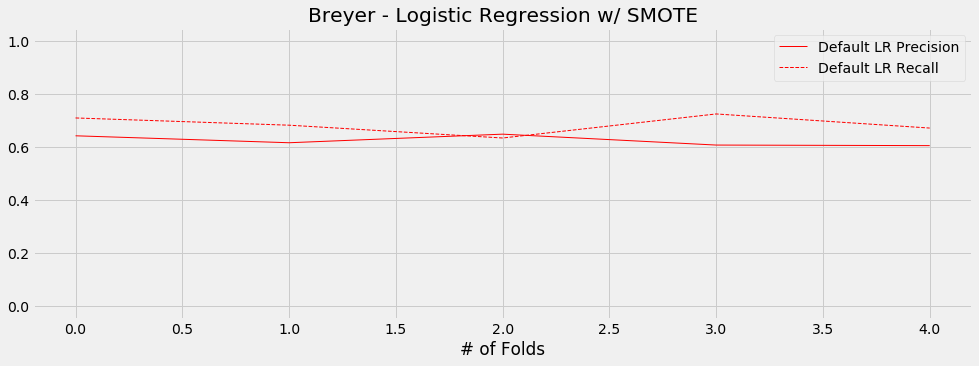

In [37]:
default_lr = LogisticRegression()

fig, ax = plt.subplots(figsize=(15, 5))
models = [default_lr]

data = pd.read_csv('data/clean/Breyer.csv')
data['cleanText'] = data['cleanText'].fillna(' ')
plot_cross_val(models, data, ax, 'smote')
ax.set_title('Breyer - Logistic Regression w/ SMOTE')
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel('# of Folds')



## Going to try a SVC now


In [45]:
model = make_pipeline(TfidfVectorizer(), 
                      SMOTE(),
                      SVC())

params = {'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
          'svc__degree': [2, 3, 4],
          'svc__gamma': ['scale', 'auto'],
          'svc__random_state': [1]}

grid = GridSearchCV(model, 
                    params, 
                    n_jobs=-1,
                    verbose=True,
                    scoring='recall')
grid.fit(X, y)

print("best parameters:", grid.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.8min finished


best parameters: {'svc__degree': 3, 'svc__gamma': 'auto', 'svc__kernel': 'poly', 'svc__random_state': 1}


In [ ]:
best_parameters= {'svc__degree': 2, 
                  'svc__gamma': 'auto', 
                  'svc__kernel': 'poly', 
                  'svc__random_state': 1}

best_smote_parameters= {'svc__degree': 3, 
                  'svc__gamma': 'auto', 
                  'svc__kernel': 'poly', 
                  'svc__random_state': 1}

Text(0.5, 0, '# of Folds')

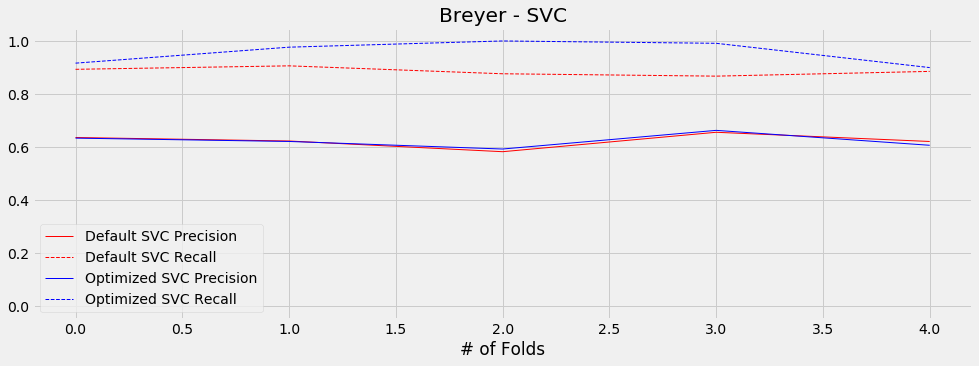

In [47]:
default_svc = SVC()
best_svc = SVC(degree=3, 
              gamma='auto', 
              kernel='poly')

fig, ax = plt.subplots(figsize=(15, 5))
models = [default_svc, best_svc]

data = pd.read_csv('data/clean/Breyer.csv')
data['cleanText'] = data['cleanText'].fillna(' ')
plot_cross_val(models, data, ax, 'smote')
ax.set_title('Breyer - SVC')
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel('# of Folds')



# Final Scores

In [50]:
data = pd.read_csv('data/clean/Breyer.csv')
X = data['cleanText'].fillna(' ').to_numpy()
y = data['vote'].to_numpy()

default_lr = LogisticRegression()

default_rf = RandomForestClassifier()
best_rf = RandomForestClassifier(criterion='entropy',
                                max_depth=3, max_features='sqrt', 
                                n_estimators=100)


default_gb = GradientBoostingClassifier()
best_gb = GradientBoostingClassifier(loss='deviance', 
                                     max_depth=None, 
                                     max_features='log2', 
                                     n_estimators=150, 
                                     learning_rate=0.01)

default_svc = SVC()
best_svc = SVC(degree=3, 
              gamma='auto', 
              kernel='poly')

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
tfidf = TfidfVectorizer()
train_vectors = tfidf.fit_transform(X_train)

train_vectors, y_train = balance_train_data(train_vectors, y_train, method='smote')

test_vectors = tfidf.transform(X_test)

In [52]:
models = [default_lr, default_rf, best_rf, default_gb, best_gb, default_svc, best_svc]
names = ['Logistic Regression', 'Default RF', 'Optimized RF', 'Default GB', 'Optimized GB', 'Default SVC', 'Optimized SVC']

pprint_list = []
pprint_list.append(['Model', 'Precision', 'Recall'])



for name, model in zip(names, models):
    model.fit(train_vectors, y_train)
    y_pred = model.predict(test_vectors)
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    pprint_list.append([name, prec, rec])

In [53]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(pprint_list)

[   ['Model', 'Precision', 'Recall'],
    ['Logistic Regression', 0.6235955056179775, 0.6894409937888198],
    ['Default RF', 0.6266094420600858, 0.906832298136646],
    ['Optimized RF', 0.6244725738396625, 0.9192546583850931],
    ['Default GB', 0.6256410256410256, 0.7577639751552795],
    ['Optimized GB', 0.6275303643724697, 0.9627329192546584],
    ['Default SVC', 0.6157205240174672, 0.8757763975155279],
    ['Optimized SVC', 0.6260162601626016, 0.9565217391304348]]


In [33]:
Counter(data['vote'])

Counter({1: 1065, 0: 650})